In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import json
from fastai.vision.all import load_learner, PILImage
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
import torch
import matplotlib.cm as cm

In [ ]:
image_root = Path("balanced_dataset_split/balanced_dataset_split/test")

def compute_metrics(img_gray):
    return {
        "brightness": np.mean(img_gray),
        "contrast": np.std(img_gray),
        "laplacian_var": cv2.Laplacian(img_gray, cv2.CV_64F).var()
    }

results = []

# Alle Bilddateien in Unterordnern durchlaufen
for img_path in tqdm(list(image_root.glob("*/*"))):
    if not img_path.is_file():
        continue
    try:
        img_gray = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img_gray is None:
            continue  

        metrics = compute_metrics(img_gray)
        results.append({
            "path": str(img_path),
            "category": img_path.parent.name,
            **metrics
        })
    except Exception as e:
        print(f"Fehler bei {img_path}: {e}")

100%|██████████| 1991/1991 [01:53<00:00, 17.56it/s]


In [7]:
df = pd.DataFrame(results)
df.to_csv("image_quality_metrics.csv", index=False)
df.head()

,path,category,brightness,contrast,laplacian_var
0,balanced_dataset_split/balanced_dataset_split/test/cn-owls/cn-owls_SUNP0317.JPG,cn-owls,125.706570,42.074086,86.771826
1,balanced_dataset_split/balanced_dataset_split/test/cn-owls/cn-owls_PICT0382.JPG,cn-owls,40.355954,61.598755,728.879634
2,balanced_dataset_split/balanced_dataset_split/test/cn-owls/cn-owls_SUNP0184-3.JPG,cn-owls,134.737378,42.888976,89.139355
3,balanced_dataset_split/balanced_dataset_split/test/cn-owls/cn-owls_SUNP0300.JPG,cn-owls,51.482183,58.497522,236.123642
4,balanced_dataset_split/balanced_dataset_split/test/cn-owls/cn-owls_PICT0689.JPG,cn-owls,32.897984,55.258768,729.707542


In [8]:
df = pd.read_csv('image_quality_metrics.csv')

# Schwellenwerte
low_brightness = 25
high_brightness = 225
low_contrast = 18

# Unterbelichtete Bilder
underexposed = df[df["brightness"] < low_brightness].copy()
underexposed["issue"] = "underexposed"

# Überbelichtete Bilder
overexposed = df[df["brightness"] > high_brightness].copy()
overexposed["issue"] = "overexposed"

# Kontrastarme Bilder
low_contrast_imgs = df[df["contrast"] < low_contrast].copy()
low_contrast_imgs["issue"] = "low_contrast"


# Alle "problematischen" Bilder zusammenführen
problem_images = pd.concat([
    underexposed,
    overexposed,
    low_contrast_imgs
], ignore_index=True)

# Ergebnisse speichern
problem_images.to_csv("problematic_images_by_fixed_thresholds.csv", index=False)

print(len(problem_images), "problematische Bilder gefunden.")

264 problematische Bilder gefunden.


In [9]:
df_problems = pd.read_csv("problematic_images_by_fixed_thresholds.csv")

# Anzahl pro Problemtyp
issue_counts = df_problems["issue"].value_counts()

print("Anzahl der Bilder pro Qualitätsproblem:")
print(issue_counts)


Anzahl der Bilder pro Qualitätsproblem:
overexposed     142
underexposed     81
low_contrast     41
Name: issue, dtype: int64


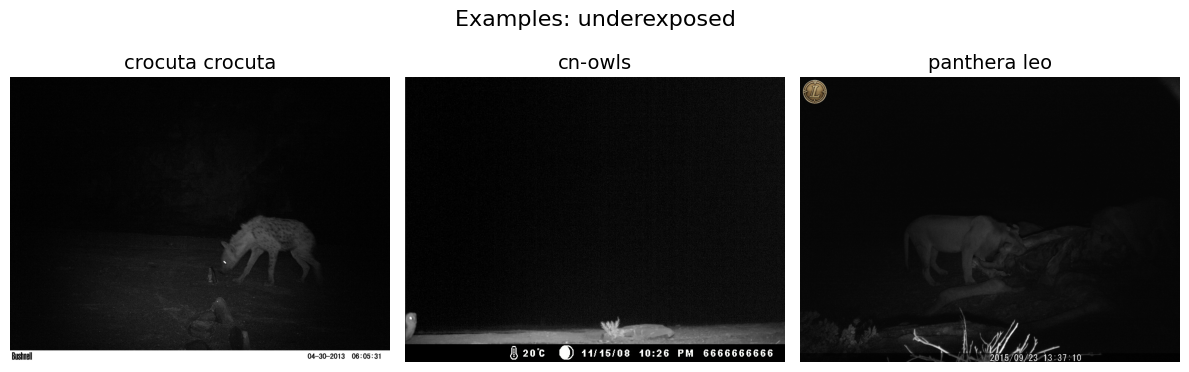

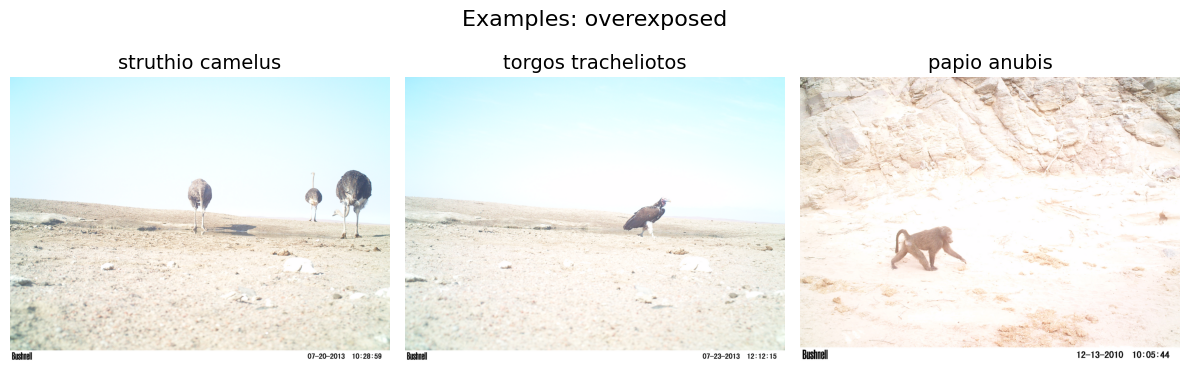

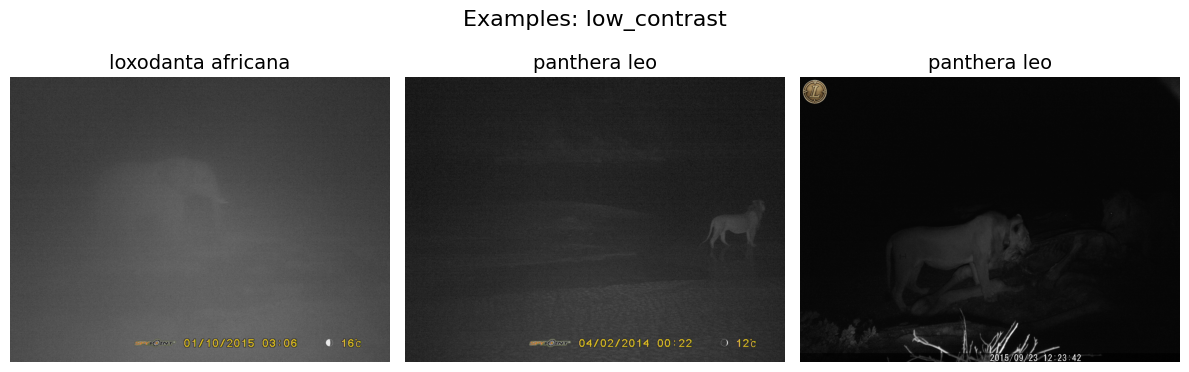

In [10]:
# CSV mit problematischen Bildern laden
df_problems = pd.read_csv("problematic_images_by_fixed_thresholds.csv")

# Liste der Problemkategorien
categories = df_problems["issue"].unique()

# Für jede Kategorie: 3 zufällige Bilder anzeigen
for category in categories:
    samples = df_problems[df_problems["issue"] == category].sample(n=3, random_state=42)

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Examples: {category}", fontsize=16)

    for i, (_, row) in enumerate(samples.iterrows()):
        img = cv2.imread(row["path"])
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(row['category'], fontsize=14)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


CBIR-Performance nur für die problematischen Bilder evaluieren:

In [11]:
# Pfade zu gespeicherten Daten
FEATURE_PATH = "CBIR/features_ViT_bs64+augm+iNat.npz"
MODEL_PATH = "basemodel_outputs/ViT_bs64+augm+iNat.pkl"
PROBLEM_CSV = "problematic_images_by_fixed_thresholds.csv"
DISTANCE_METRIC = "cosine"
TOP_K = 5

In [ ]:
# gespeicherte Features laden
data = np.load(FEATURE_PATH)
features_array = data["features"]
labels_array = data["labels"]

# Modell laden
learn = load_learner(MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learn.model = learn.model.to(device)

# Lade problematische Bilder
df_problems = pd.read_csv(PROBLEM_CSV)

In [99]:
# Feature-Extraktion
def extract_features(learn, img_path):
    img = PILImage.create(img_path)
    img = learn.dls.test_dl([img]).one_batch()[0]
    img = img.to(device)
    with torch.no_grad():
        feats = learn.model(img)
    if feats.ndim == 4:
        feats = torch.nn.functional.adaptive_avg_pool2d(feats, (1, 1)).squeeze()
    elif feats.ndim == 3:
        feats = feats.mean(dim=(-1, -2))
    if feats.ndim == 2:
        feats = feats.squeeze(0)
    return feats.cpu().numpy()

# CBIR-Suche
def search(query_feat, database_feats, metric="cosine", top_k=5):
    if metric == "cosine":
        sims = cosine_similarity([query_feat], database_feats)[0]
        top_indices = np.argsort(sims)[::-1][:top_k]
        scores = sims[top_indices]
    elif metric == "euclidean":
        dists = euclidean_distances([query_feat], database_feats)[0]
        top_indices = np.argsort(dists)[:top_k]
        scores = dists[top_indices]
    elif metric == "manhattan":
        dists = manhattan_distances([query_feat], database_feats)[0]
        top_indices = np.argsort(dists)[:top_k]
        scores = dists[top_indices]
    else:
        raise ValueError("Unknown metric")
    return top_indices, scores

# Metriken
def precision_at_k(query_label, retrieved_labels, k):
    correct = sum([1 for label in retrieved_labels[:k] if label == query_label])
    return correct / k

def average_precision(query_label, retrieved_labels):
    relevant = [1 if label == query_label else 0 for label in retrieved_labels]
    if sum(relevant) == 0:
        return 0
    precisions = [precision_at_k(query_label, retrieved_labels, k+1) for k in range(len(relevant)) if relevant[k]]
    return np.mean(precisions)

In [ ]:
# Evaluation starten
results = []

for i, row in df_problems.iterrows():
    img_path = row["path"]
    issue_label = row["issue"]
    query_feat = extract_features(learn, img_path)
    query_label = os.path.basename(os.path.dirname(img_path))

    top_indices, scores = search(query_feat, features_array, metric=DISTANCE_METRIC, top_k=TOP_K + 1)
    top_indices = top_indices[1:]
    scores = scores[1:]
    retrieved_labels = labels_array[top_indices]

    precision = precision_at_k(query_label, retrieved_labels, k=TOP_K)
    recall = sum([1 for label in retrieved_labels if label == query_label]) / sum(labels_array == query_label)
    ap = average_precision(query_label, retrieved_labels)
    top1 = 1 if retrieved_labels[0] == query_label else 0

    results.append({
        "Path": img_path,
        "Issue": issue_label,
        "Query Label": query_label,
        "Precision@5": precision,
        "AP": ap,
        "Top-1 Accuracy": top1
    })

# Ergebnisse als DataFrame
df_eval_problems = pd.DataFrame(results)

# Gruppierte Übersicht
summary = df_eval_problems.groupby("Issue")[["Precision@5", "AP", "Top-1 Accuracy"]].mean()
print("Durchschnittswerte pro Bildproblem:\n")
print(summary.round(4))


📊 Durchschnittswerte pro Bildproblem:

              Precision@5      AP  Top-1 Accuracy
Issue                                            
low_contrast       0.9122  0.9323          0.9024
overexposed        0.8746  0.8812          0.8592
underexposed       0.8395  0.8870          0.8889


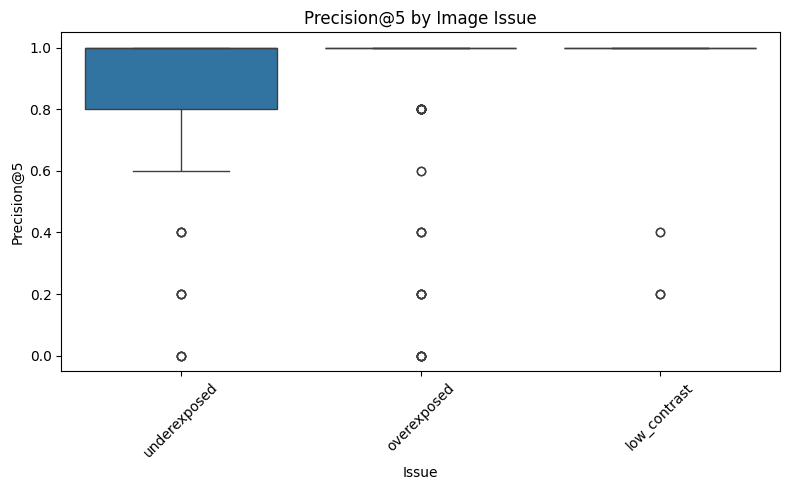

In [ ]:
# Visualisierung
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_eval_problems, x="Issue", y="Precision@5")
plt.title("Precision@5 by Image Issue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2669088/502741612.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_eval_problems, x="Issue", y="AP", ci=None)


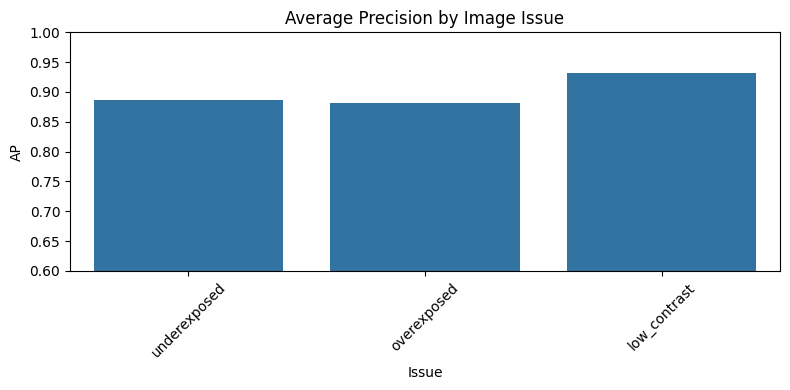

In [ ]:
# Visualisierung
plt.figure(figsize=(8, 4))
sns.barplot(data=df_eval_problems, x="Issue", y="AP", ci=None)
plt.title("Average Precision by Image Issue")
plt.ylim(0.6, 1.0) 
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/barplot_AP_by_image_issue.png", dpi=300)
plt.show()

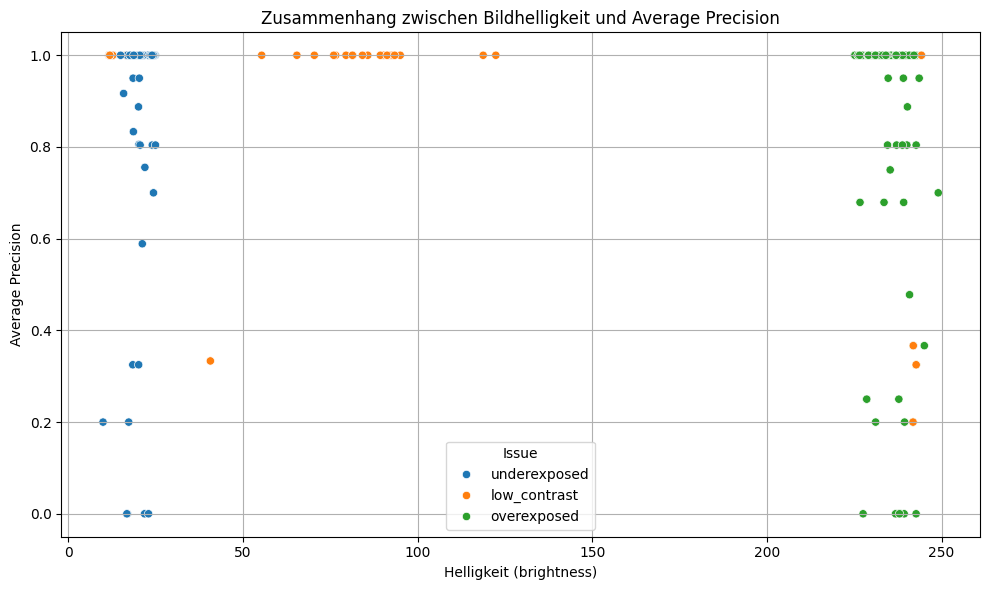

In [101]:
# Beispiel für brightness vs AP
merged = pd.merge(df_eval_problems, df[["path", "brightness", "contrast"]], left_on="Path", right_on="path")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x="brightness", y="AP", hue="Issue")
plt.title("Zusammenhang zwischen Bildhelligkeit und Average Precision")
plt.xlabel("Helligkeit (brightness)")
plt.ylabel("Average Precision")
plt.grid(True)
plt.tight_layout()
plt.show()


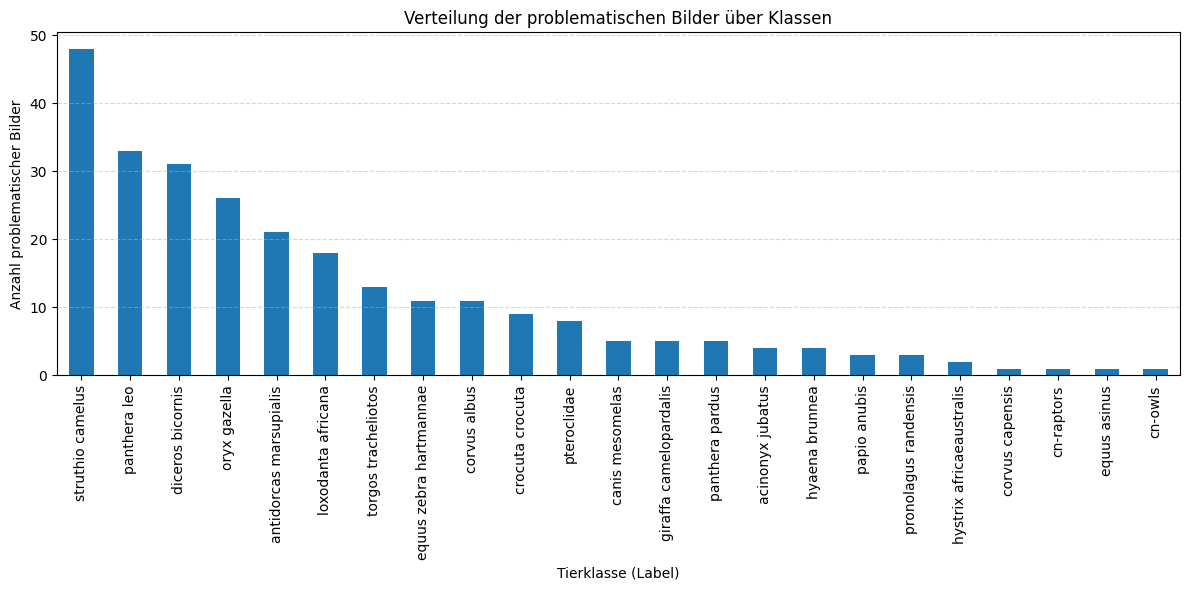

In [ ]:
query_label = os.path.basename(os.path.dirname(img_path))


plt.figure(figsize=(12, 6))
df_eval_problems["Query Label"].value_counts().plot(kind="bar")
plt.title("Verteilung der problematischen Bilder über Klassen")
plt.xlabel("Tierklasse (Label)")
plt.ylabel("Anzahl problematischer Bilder")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


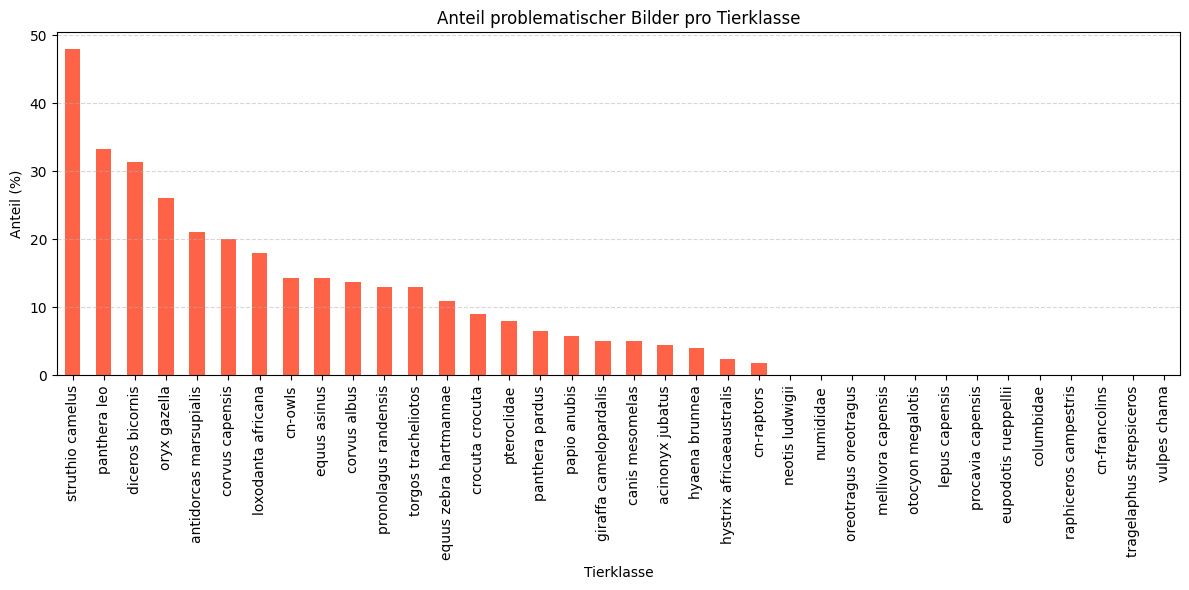

In [106]:
# image_quality_metrics.csv enthält brightness, contrast etc. für alle Bilder inkl. Pfade
df_all = pd.read_csv("image_quality_metrics.csv")
df_problems = pd.read_csv("problematic_images_by_fixed_thresholds.csv")

# Klasse aus dem Pfad extrahieren (wie bei CBIR-Auswertung)
df_all["label"] = df_all["path"].apply(lambda x: os.path.basename(os.path.dirname(x)))
df_problems["label"] = df_problems["path"].apply(lambda x: os.path.basename(os.path.dirname(x)))

# Gesamtanzahl Bilder pro Klasse
total_per_class = df_all["label"].value_counts().sort_index()

# Anzahl problematischer Bilder pro Klasse
problem_per_class = df_problems["label"].value_counts().sort_index()

# Zusammenführen und fehlende Klassen mit 0 füllen
df_ratio = pd.DataFrame({
    "Total": total_per_class,
    "Problematic": problem_per_class
}).fillna(0)

# Prozentanteil berechnen
df_ratio["Percent Problematic"] = (df_ratio["Problematic"] / df_ratio["Total"]) * 100

# Sortieren nach höchstem Anteil
df_ratio_sorted = df_ratio.sort_values("Percent Problematic", ascending=False)


#Visualisierung
plt.figure(figsize=(12, 6))
df_ratio_sorted["Percent Problematic"].plot(kind="bar", color="tomato")
plt.title("Anteil problematischer Bilder pro Tierklasse")
plt.ylabel("Anteil (%)")
plt.xlabel("Tierklasse")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [109]:
# Nur die "guten" Klassen (unter 20% Problem-Bilder)
clean_classes = df_ratio_sorted[df_ratio_sorted["Percent Problematic"] < 20].index.tolist()

# Nur CBIR-Ergebnisse mit Klassen aus clean_classes behalten
df_eval_clean = df_eval_problems[df_eval_problems["Query Label"].isin(clean_classes)]

summary_clean = df_eval_clean[["Precision@5", "AP", "Top-1 Accuracy"]].mean()
print("\n📊 Durchschnittliche Metriken für Klassen mit < 20% problematischen Bildern:")
print(summary_clean.round(4))



📊 Durchschnittliche Metriken für Klassen mit < 20% problematischen Bildern:
Precision@5       0.7981
AP                0.8363
Top-1 Accuracy    0.8077
dtype: float64


In [ ]:
df_eval_problematic = df_eval_problems[~df_eval_problems["Query Label"].isin(clean_classes)]

summary_problematic = df_eval_problematic[["Precision@5", "AP", "Top-1 Accuracy"]].mean()

# Zusammenführen
comparison = pd.DataFrame({
    "Clean Classes (<20%)": summary_clean,
    "Problematic Classes (≥20%)": summary_problematic
}).round(4)

print("Vergleich der CBIR-Performance:\n")
print(comparison)


📊 Vergleich der CBIR-Performance:

                Clean Classes (<20%)  Problematic Classes (≥20%)
Precision@5                   0.7981                      0.9162
AP                            0.8363                      0.9264
Top-1 Accuracy                0.8077                      0.9188



📊 Vergleich aller drei Gruppen:
                Low-Quality-Issue Classes  High-Quality-Issue Classes  \
Precision@5                        0.7981                      0.9162   
AP                                 0.8363                      0.9264   
Top-1 Accuracy                     0.8077                      0.9188   

                Entire Evaluation Set  
Precision@5                    0.8697  
AP                             0.8909  
Top-1 Accuracy                 0.8750  


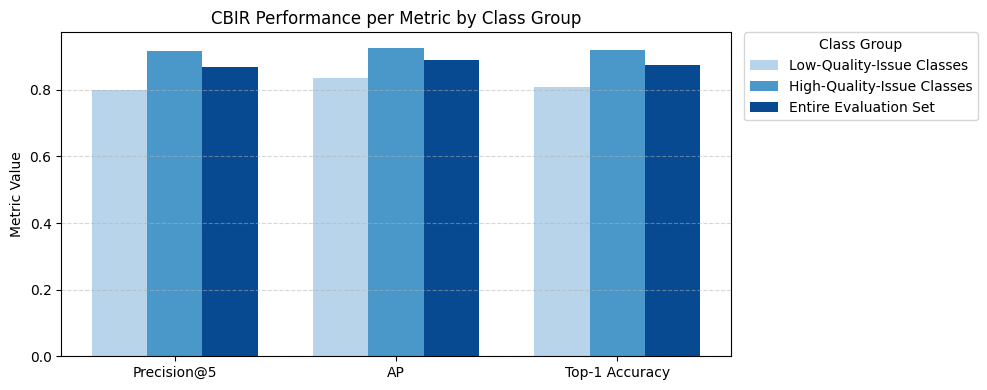

In [ ]:
# Gesamtdurchschnitt (alle CBIR-Bilder aus df_eval_problems)
summary_total = df_eval_problems[["Precision@5", "AP", "Top-1 Accuracy"]].mean()

# Vergleich zusammenstellen
comparison_all = pd.DataFrame({
    "Low-Quality-Issue Classes": summary_clean,
    "High-Quality-Issue Classes": summary_problematic,
    "Entire Evaluation Set": summary_total
}).round(4)

print("Vergleich aller drei Gruppen:")
print(comparison_all)


# Metriken & Gruppen vorbereiten
metrics = comparison_all.index.tolist()
groups = comparison_all.columns.tolist()
values = comparison_all.values.T  # shape: (3 groups, 4 metrics)

x = np.arange(len(metrics))
width = 0.25

# Farben aus Colormap "Blues"
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(groups)))

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

for i, (group, color) in enumerate(zip(groups, colors)):
    ax.bar(x + i * width, values[i], width=width, label=group, color=color)

# Achsenbeschriftung und Titel
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.set_ylabel("Metric Value")
ax.set_title("CBIR Performance per Metric by Class Group")
ax.grid(axis="y", linestyle="--", alpha=0.5)

# Legende rechts neben dem Plot
ax.legend(title="Class Group", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.show()


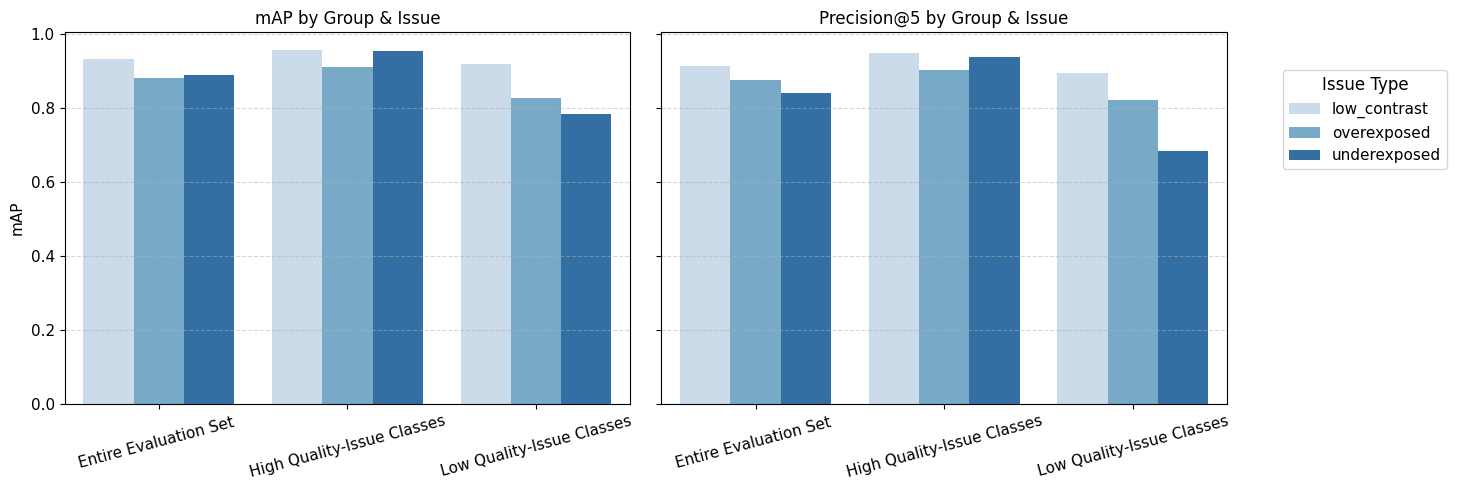

In [ ]:
# Gruppennamen anpassen (ohne 20% Hinweise)
plot_df["Class Group Short"] = plot_df["Class Group (w. All)"].replace({
    "Low Quality-Issue Classes (<20%)": "Low Quality-Issue Classes",
    "High Quality-Issue Classes (≥20%)": "High Quality-Issue Classes",
    "All Test Classes": "Entire Evaluation Set "
})

# mAP-Umbenennung
plot_df = plot_df.rename(columns={"AP": "mAP"})

# Figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: mAP
sns.barplot(
    data=plot_df,
    x="Class Group Short",
    y="mAP",
    hue="Issue",
    palette="Blues",
    ax=axes[0]
)
axes[0].set_title("mAP by Group & Issue", fontsize=12)
axes[0].set_ylabel("mAP", fontsize=11)
axes[0].set_xlabel("", fontsize=11)
axes[0].tick_params(axis='x', labelsize=11, rotation=15)
axes[0].tick_params(axis='y', labelsize=11)
axes[0].grid(axis="y", linestyle="--", alpha=0.5)

# Plot 2: Precision@5
sns.barplot(
    data=plot_df,
    x="Class Group Short",
    y="Precision@5",
    hue="Issue",
    palette="Blues",
    ax=axes[1]
)
axes[1].set_title("Precision@5 by Group & Issue", fontsize=12)
axes[1].set_ylabel("", fontsize=11)
axes[1].set_xlabel("", fontsize=11)
axes[1].tick_params(axis='x', labelsize=11, rotation=15)
axes[1].tick_params(axis='y', labelsize=11)
axes[1].grid(axis="y", linestyle="--", alpha=0.5)

handles, labels = axes[1].get_legend_handles_labels()
fig.legend(
    handles, labels, title="Issue Type",
    title_fontsize=12,
    fontsize=11,
    bbox_to_anchor=(0.92, 0.85), loc="upper left", borderaxespad=0
)

# Einzelne Legenden entfernen
axes[0].legend_.remove()
axes[1].legend_.remove()

# Layout
plt.tight_layout()
plt.subplots_adjust(right=0.88)
plt.savefig("images/cbir_qualityissues_groups.png", format="png", dpi=300, bbox_inches="tight")
plt.show()


## Tag-/Nachtbilder

In [137]:
# Tageszeit-CSV laden
df_daynight = pd.read_csv("color_based_classification_final.csv")
df_daynight["Image Path"] = df_daynight["Image Path"]

# CBIR-Ergebnisse laden
df_cbir = pd.read_csv("CBIR/cbir_detailed_ViT_bs64+augm+iNat_cosine.csv")
df_cbir["Path"] = df_cbir["Path"].str.replace(r"^\.\./balanced_dataset_split/", "", regex=True)

# Tageszeit hinzufügen
df_combined = pd.merge(df_cbir, df_daynight, left_on="Path", right_on="Image Path", how="left")

# Ergebnis prüfen
print(df_combined["Classification"].value_counts(dropna=False))


Day      1260
Night     731
Name: Classification, dtype: int64


In [138]:
# Gruppieren nach Tageszeit
df_daynight_summary = df_combined.groupby("Classification")[["Precision@5", "Recall@5", "AP", "Top-1 Accuracy"]].mean().round(4)
print(df_daynight_summary)

                Precision@5  Recall@5      AP  Top-1 Accuracy
Classification                                               
Day                  0.8929    0.0812  0.9264          0.9183
Night                0.8170    0.0678  0.8746          0.8564



⚠️ Keine 'Brightness'-Spalte gefunden – Korrelation übersprungen.


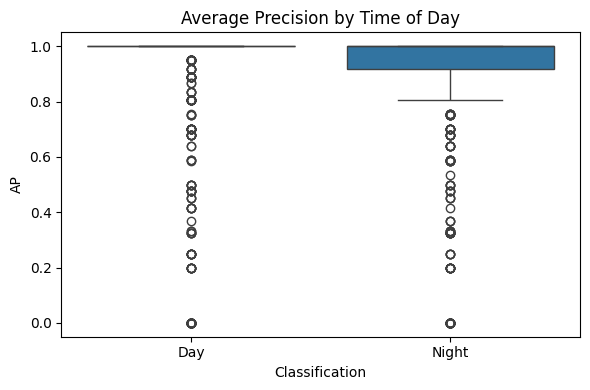

In [ ]:
# 2Klassenweise mAP bei Tag/Nacht
df_classwise = df_combined.groupby(["Query Label", "Classification"])["AP"].mean().reset_index()
df_classwise_pivot = df_classwise.pivot(index="Query Label", columns="Classification", values="AP").fillna(0)

# Boxplot: AP nach Tageszeit
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_combined, x="Classification", y="AP")
plt.title("Average Precision by Time of Day")
plt.tight_layout()
plt.savefig("images/boxplot_ap_daynight.png", dpi=300)
plt.show()

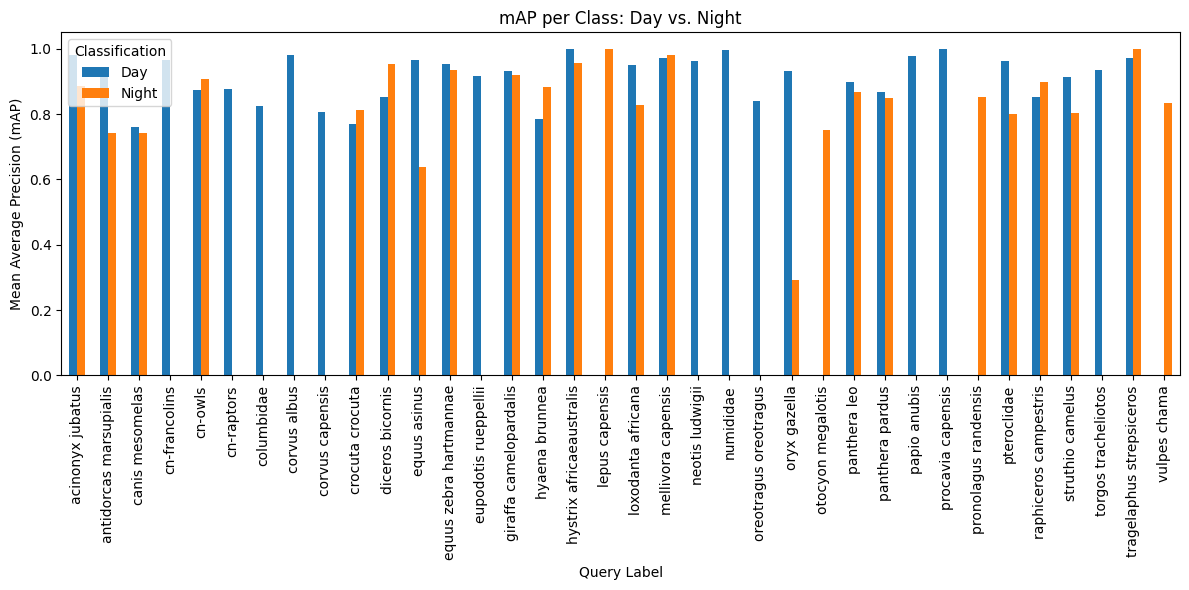

In [ ]:
# Balkendiagramm: mAP je Klasse bei Tag/Nacht
df_classwise_pivot.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Mean Average Precision (mAP)")
plt.title("mAP per Class: Day vs. Night")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("images/barplot_map_per_class_daynight.png", dpi=300)
plt.show()

/tmp/ipykernel_2669088/813803544.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues_color = cm.get_cmap("Blues")(0.8)  # Wert zwischen 0 (hell) und 1 (dunkelblau)


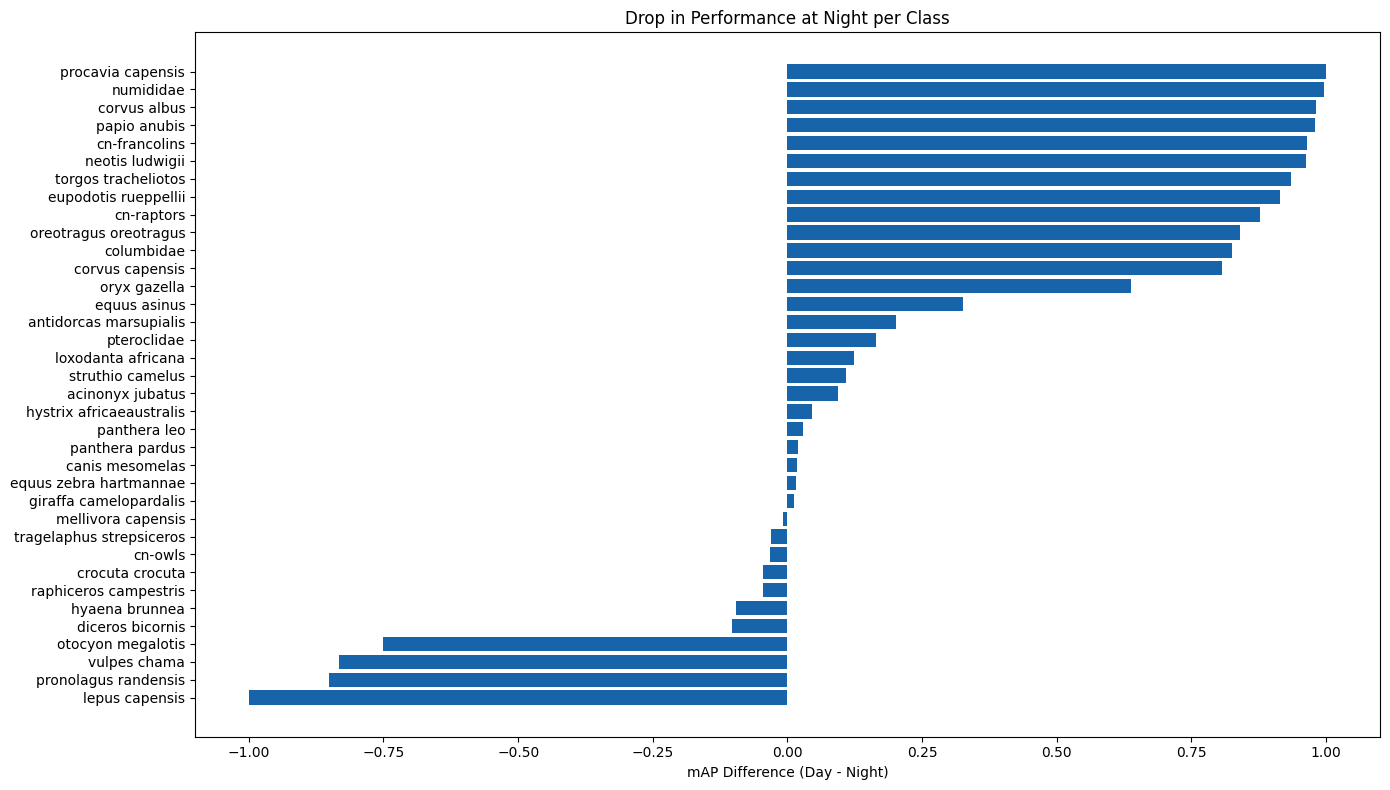

In [ ]:
# Farbton aus der Blues-Colormap 
blues_color = cm.get_cmap("Blues")(0.8) 

# Sortieren und Plotten
delta_sorted = df_classwise_pivot["Delta"].sort_values()

plt.figure(figsize=(14, 8))
plt.barh(delta_sorted.index, delta_sorted.values, color=blues_color)
plt.xlabel("mAP Difference (Day - Night)")
plt.title("Drop in Performance at Night per Class")
plt.tight_layout()
plt.savefig("images/delta_map_night_vs_day.png", dpi=300)
plt.show()

/tmp/ipykernel_2669088/3231483217.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap("Blues")


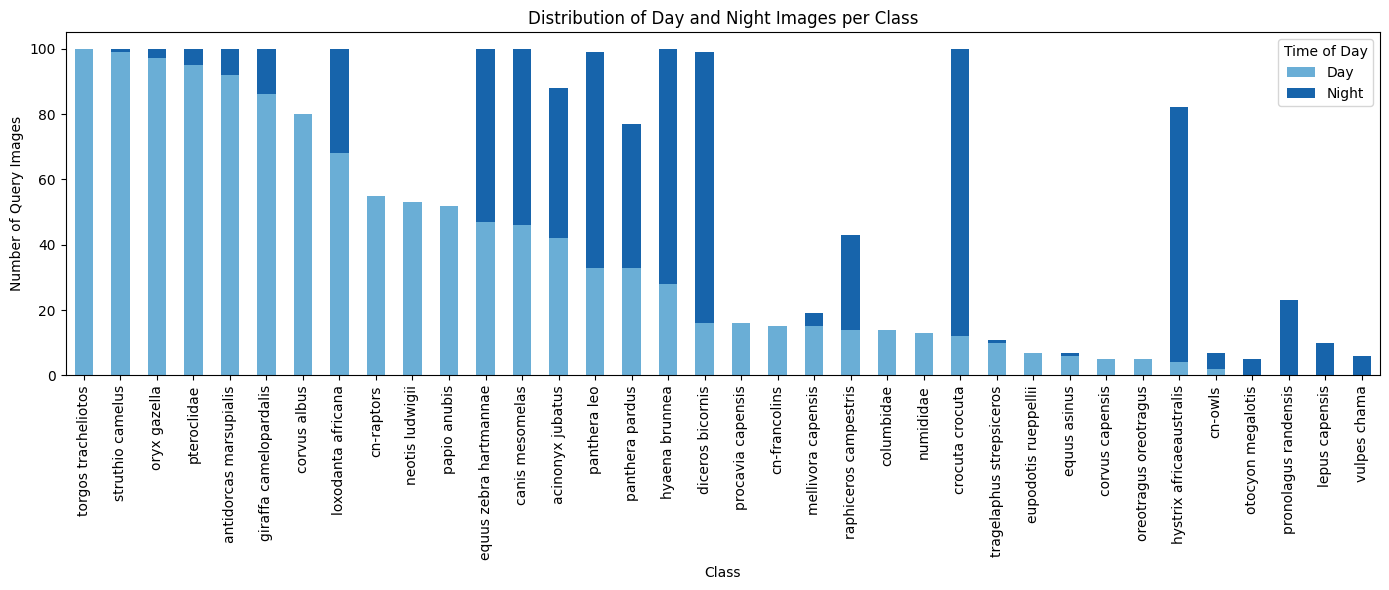

In [ ]:
# Farbwerte aus der 'Blues'-Colormap
blues = cm.get_cmap("Blues")
day_color = blues(0.5)
night_color = blues(0.8)
custom_colors = [day_color, night_color]

# Gruppieren: Anzahl Day/Night je Klasse
class_distribution = df_combined.groupby(["Query Label", "Classification"]).size().unstack(fill_value=0)

# Sortieren nach Anzahl Day-Bilder 
if "Day" in class_distribution.columns:
    class_distribution = class_distribution.sort_values(by="Day", ascending=False)

# Plot
class_distribution.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 6),
    color=custom_colors
)

plt.title("Distribution of Day and Night Images per Class")
plt.ylabel("Number of Query Images")
plt.xlabel("Class")
plt.xticks(rotation=90)
plt.legend(title="Time of Day")
plt.tight_layout()
plt.savefig("images/day_night_distribution_per_class.png", dpi=300)
plt.show()

In [ ]:
# Anzahl der Tag- und Nachtbilder je Klasse
class_distribution = df_combined.groupby(["Query Label", "Classification"]).size().unstack(fill_value=0)

# Durchschnittliches mAP pro Klasse und Tageszeit
map_per_class_time = df_combined.groupby(["Query Label", "Classification"])["AP"].mean().unstack()

# Tabelle zusammenbauen
summary_table = pd.DataFrame()
summary_table["# Day"] = class_distribution.get("Day", 0)
summary_table["# Night"] = class_distribution.get("Night", 0)
summary_table["Day:Night Ratio"] = summary_table["# Day"].astype(str) + ":" + summary_table["# Night"].astype(str)
summary_table["mAP Day"] = map_per_class_time.get("Day", float('nan')).round(3)
summary_table["mAP Night"] = map_per_class_time.get("Night", float('nan')).round(3)
summary_table["Δ mAP (Day - Night)"] = (summary_table["mAP Day"] - summary_table["mAP Night"]).round(3)

# Nach Anzahl der Day-Bilder sortieren oder nach Drop
summary_table = summary_table.sort_values(by="# Day", ascending=False)

summary_table.to_csv("summary_day_night_cbir.csv", index=True)

print(summary_table)

                          # Day  # Night Day:Night Ratio  mAP Day  mAP Night  \
Query Label                                                                    
torgos tracheliotos         100        0           100:0    0.935        NaN   
struthio camelus             99        1            99:1    0.912      0.804   
oryx gazella                 97        3            97:3    0.931      0.293   
pteroclidae                  95        5            95:5    0.963      0.800   
antidorcas marsupialis       92        8            92:8    0.944      0.743   
giraffa camelopardalis       86       14           86:14    0.932      0.921   
corvus albus                 80        0            80:0    0.980        NaN   
loxodanta africana           68       32           68:32    0.951      0.827   
cn-raptors                   55        0            55:0    0.877        NaN   
neotis ludwigii              53        0            53:0    0.963        NaN   
papio anubis                 52        0

## Abgeschnittene Tiere / viele Tiere

In [ ]:
# JSON laden
with open("balanced_dataset_detections_60.json", "r") as f:
    data = json.load(f)

# BBox-Fläche extrahieren 
records = []
for img in data["images"]:
    path = img["file"]
    boxes = [det["bbox"] for det in img["detections"] if det["category"] == "1"]
    areas = [w * h for _, _, w, h in boxes]  # relative Fläche
    max_area = max(areas) if areas else 0
    sum_area = sum(areas) if areas else 0
    records.append({"Path": path, "BBox Area (Max)": max_area, "BBox Area (Sum)": sum_area})

df_bbox = pd.DataFrame(records)

df_bbox.head()

,Path,BBox Area (Max),BBox Area (Sum)
0,acinonyx jubatus/acinonyx jubatus_20150830-PICT0034.JPG,0.116391,0.116391
1,acinonyx jubatus/acinonyx jubatus_20170218-PICT0052.JPG,0.054895,0.081865
2,acinonyx jubatus/acinonyx jubatus_20170218-PICT0053.JPG,0.048809,0.048809
3,acinonyx jubatus/acinonyx jubatus_20170218-PICT0055.JPG,0.020528,0.037743
4,acinonyx jubatus/acinonyx jubatus_20170218-PICT0056.JPG,0.018330,0.033834


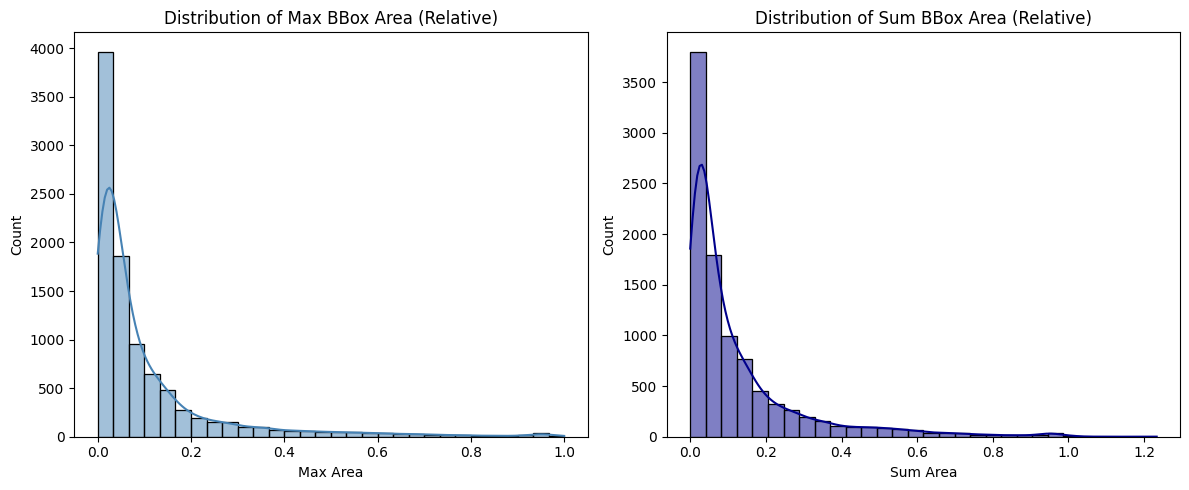

In [ ]:
plt.figure(figsize=(12, 5))

# Max-Area
plt.subplot(1, 2, 1)
sns.histplot(df_bbox["BBox Area (Max)"], bins=30, kde=True, color="steelblue")
plt.title("Distribution of Max BBox Area (Relative)")
plt.xlabel("Max Area")
plt.ylabel("Count")

# Sum-Area
plt.subplot(1, 2, 2)
sns.histplot(df_bbox["BBox Area (Sum)"], bins=30, kde=True, color="darkblue")
plt.title("Distribution of Sum BBox Area (Relative)")
plt.xlabel("Sum Area")
plt.ylabel("Count")

plt.tight_layout()
#plt.savefig("images/distribution_bbox_areas.png", dpi=300)
plt.show()


In [ ]:
# CBIR-Daten laden
df_cbir = pd.read_csv("CBIR/cbir_detailed_ViT_bs64+augm+iNat_cosine.csv")

# ../ entfernen für Matching
df_cbir["Path"] = df_cbir["Path"].str.replace(r"^\.\./balanced_dataset_split/balanced_dataset_split/test/", "", regex=True)

# Merge mit BBox-Flächen
df_combined = pd.merge(df_cbir, df_bbox, on="Path", how="left")


print("Anzahl gematchter Bilder mit Bounding Boxes:", df_combined["BBox Area (Max)"].notna().sum())
print("Länge df_combined: ", len(df_combined))

df_combined.head()


Anzahl gematchter Bilder mit Bounding Boxes: 1898
Länge df_combined:  1991


,Path,Precision@5,AP,Top-1 Accuracy,Recall@5,Search Time (s),Query Label,BBox Area (Max),BBox Area (Sum)
0,acinonyx jubatus/acinonyx jubatus_20140307-PICT0221.JPG,1.0,1.000000,1,0.057471,0.000532,acinonyx jubatus,0.017087,0.017087
1,acinonyx jubatus/acinonyx jubatus_20140307-PICT0230.JPG,0.6,0.477778,0,0.034483,0.000401,acinonyx jubatus,0.034553,0.034553
2,acinonyx jubatus/acinonyx jubatus_20140307-PICT0231.JPG,1.0,1.000000,1,0.057471,0.000414,acinonyx jubatus,0.014401,0.014401
3,acinonyx jubatus/acinonyx jubatus_20140307-PICT0233.JPG,1.0,1.000000,1,0.057471,0.000376,acinonyx jubatus,0.013304,0.013304
4,acinonyx jubatus/acinonyx jubatus_20140307-PICT0234.JPG,1.0,1.000000,1,0.057471,0.000369,acinonyx jubatus,0.023607,0.023607


Small objects: 288 images
Large objects: 14 images
Durchschnittswerte bei kleinen Objekten:
Precision@5       0.850694
Recall@5          0.109230
AP                0.899344
Top-1 Accuracy    0.885417
dtype: float64

Durchschnittswerte bei großen Objekten:
Precision@5       0.928571
Recall@5          0.069081
AP                0.950694
Top-1 Accuracy    1.000000
dtype: float64


/tmp/ipykernel_2897000/4065669994.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=ap_means, palette="Blues")


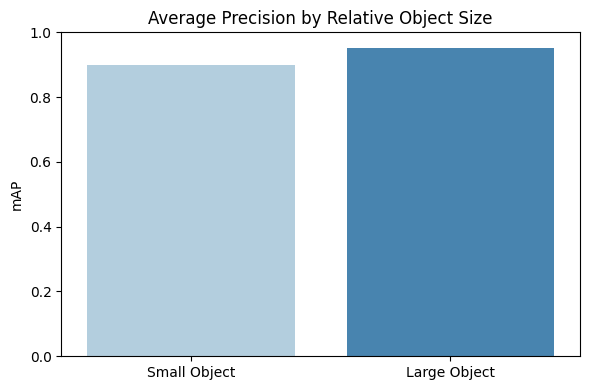

In [15]:
# Subsets
df_small = df_combined[df_combined["BBox Area (Max)"] < 0.01]
df_large = df_combined[df_combined["BBox Area (Max)"] > 0.9]

print(f"Small objects: {len(df_small)} images")
print(f"Large objects: {len(df_large)} images")

print("Durchschnittswerte bei kleinen Objekten:")
print(df_small[["Precision@5", "Recall@5", "AP", "Top-1 Accuracy"]].mean())

print("\nDurchschnittswerte bei großen Objekten:")
print(df_large[["Precision@5", "Recall@5", "AP", "Top-1 Accuracy"]].mean())

import matplotlib.pyplot as plt

ap_means = [df_small["AP"].mean(), df_large["AP"].mean()]
labels = ["Small Object", "Large Object"]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=ap_means, palette="Blues")
plt.title("Average Precision by Relative Object Size")
plt.ylabel("mAP")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("images/ap_small_vs_large_objects.png", dpi=300)
plt.show()

In [16]:
# Abgeschnittene Tiere (Tiere am Rand)

# Daten vorbereiten
edge_info = []

for img in data["images"]:
    path = img["file"]
    boxes = [det["bbox"] for det in img["detections"] if det["category"] == "1"]
    edge = False

    for x, y, w, h in boxes:
        if x < 0.05 or x + w > 0.95 or y < 0.05 or y + h > 0.95:
            edge = True
            break  # reicht, wenn eine BBox betroffen ist

    edge_info.append({"Path": path, "Touches Edge": edge})

df_edges = pd.DataFrame(edge_info)

df_edges.head()

,Path,Touches Edge
0,acinonyx jubatus/acinonyx jubatus_20150830-PICT0034.JPG,True
1,acinonyx jubatus/acinonyx jubatus_20170218-PICT0052.JPG,False
2,acinonyx jubatus/acinonyx jubatus_20170218-PICT0053.JPG,False
3,acinonyx jubatus/acinonyx jubatus_20170218-PICT0055.JPG,False
4,acinonyx jubatus/acinonyx jubatus_20170218-PICT0056.JPG,False


In [17]:
df_cbir["Path"] = df_cbir["Path"].str.replace(r"^\.\./", "", regex=True)
df_edge_merged = pd.merge(df_cbir, df_edges, on="Path", how="left")

df_edge_merged["Touches Edge"] = df_edge_merged["Touches Edge"].fillna(False)

df_edge_stats = df_edge_merged.groupby("Touches Edge")[["Precision@5", "Recall@5", "AP", "Top-1 Accuracy"]].mean()
print(df_edge_stats)


              Precision@5  Recall@5        AP  Top-1 Accuracy
Touches Edge                                                 
False            0.859351  0.082389  0.911313        0.897901
True             0.871262  0.069542  0.903034        0.892895


/tmp/ipykernel_2897000/1244552657.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


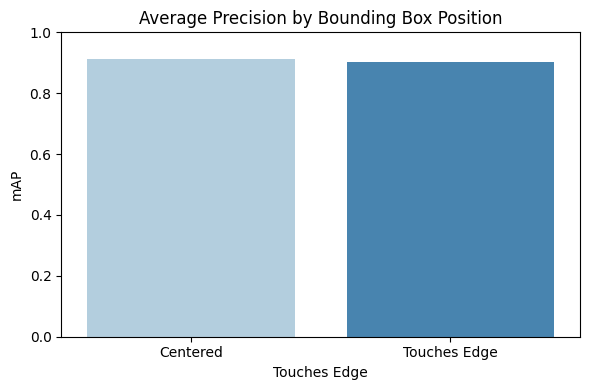

In [18]:
plt.figure(figsize=(6, 4))
sns.barplot(
    x=df_edge_stats.index.map({False: "Centered", True: "Touches Edge"}),
    y=df_edge_stats["AP"].values,
    palette="Blues"
)
plt.title("Average Precision by Bounding Box Position")
plt.ylabel("mAP")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("images/ap_bbox_edge_vs_centered.png", dpi=300)
plt.show()


In [55]:
#nochmal: nur die auch rand berühren

# Sammlung einzelner BBoxes mit Randkontakt
edge_bboxes = []

for img in data["images"]:
    img_path = img["file"]
    for det in img["detections"]:
        if det["category"] != "1":
            continue  # Nur Tiere

        x, y, w, h = det["bbox"]
        touches_edge = x < 0.05 or (x + w) > 0.95 or y < 0.05 or (y + h) > 0.95
        if touches_edge:
            area = w * h
            edge_bboxes.append({
                "Path": img_path,
                "x": x, "y": y, "w": w, "h": h,
                "Area": area,
                "Touches Edge": True
            })

df_edge_bboxes = pd.DataFrame(edge_bboxes)
df_edge_bboxes.head()

,Path,x,y,w,h,Area,Touches Edge
0,acinonyx jubatus/acinonyx jubatus_20150830-PICT0034.JPG,0.657300,0.517500,0.2553,0.4559,0.116391,True
1,acinonyx jubatus/acinonyx jubatus_20170218-PICT0020.JPG,0.000000,0.001041,1.0000,0.9619,0.961900,True
2,acinonyx jubatus/acinonyx jubatus_20170218-PICT0023.JPG,0.002343,0.000521,0.8050,0.9156,0.737058,True
3,acinonyx jubatus/acinonyx jubatus_20170218-PICT0024.JPG,0.000000,0.000000,0.9281,0.9640,0.894688,True
4,acinonyx jubatus/acinonyx jubatus_20170218-PICT0025.JPG,0.577300,0.069270,0.3847,0.8937,0.343806,True


In [56]:
print(len(df_edge_bboxes))

6165


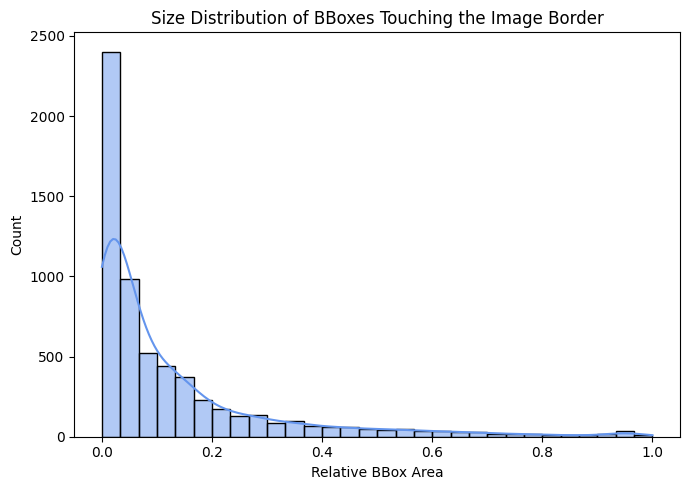

In [20]:
plt.figure(figsize=(7, 5))
sns.histplot(df_edge_bboxes["Area"], bins=30, kde=True, color="cornflowerblue")
plt.title("Size Distribution of BBoxes Touching the Image Border")
plt.xlabel("Relative BBox Area")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("images/bbox_area_distribution_edge_only.png", dpi=300)
plt.show()


[ WARN:0@12201.815] global loadsave.cpp:268 findDecoder imread_('balanced_dataset_split/balanced_dataset_split/test/oryx gazella/oryx gazella_20110208-PICT5357.JPG'): can't open/read file: check file path/integrity
[ WARN:0@12201.902] global loadsave.cpp:268 findDecoder imread_('balanced_dataset_split/balanced_dataset_split/test/pteroclidae/pteroclidae_20170201-PICT1751.JPG'): can't open/read file: check file path/integrity
[ WARN:0@12201.902] global loadsave.cpp:268 findDecoder imread_('balanced_dataset_split/balanced_dataset_split/test/pteroclidae/pteroclidae_20160322-PICT2932.JPG'): can't open/read file: check file path/integrity


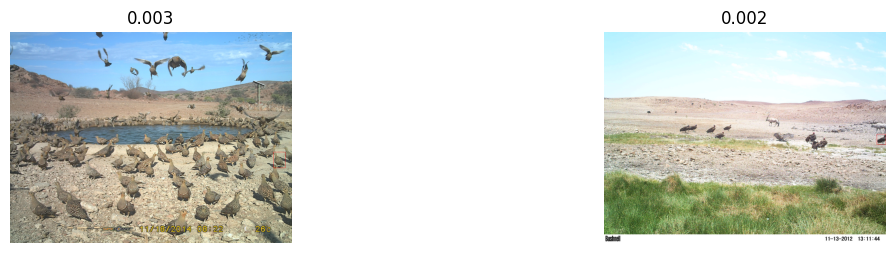

In [ ]:
import cv2

# Filter für kleine Boxen mit Randkontakt
small_edge_boxes = df_edge_bboxes[df_edge_bboxes["Area"] < 0.01].sample(n=5, random_state=42)

# Bilder anzeigen
plt.figure(figsize=(15, 4))
for i, row in enumerate(small_edge_boxes.itertuples()):
    img_path = os.path.join("balanced_dataset_split/balanced_dataset_split/test/", row.Path)
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # BBox in absoluten Pixeln zeichnen
    h_img, w_img = img.shape[:2]
    x1 = int(row.x * w_img)
    y1 = int(row.y * h_img)
    x2 = int((row.x + row.w) * w_img)
    y2 = int((row.y + row.h) * h_img)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"{row.Area:.3f}")
    plt.axis("off")

plt.tight_layout()
plt.savefig("images/sample_edge_boxes_small.png", dpi=300)
plt.show()


In [58]:
# nur 1 bbox im Bild und diese am Rand 

edge_single_bboxes = []

for img in data["images"]:
    img_path = img["file"]
    # Alle BBoxes der Kategorie "1"
    boxes = [det["bbox"] for det in img["detections"] if det["category"] == "1"]

    # Nur Bilder mit genau einer BBox
    if len(boxes) == 1:
        x, y, w, h = boxes[0]
        touches_edge = x < 0.05 or (x + w) > 0.95 or y < 0.05 or (y + h) > 0.95
        if touches_edge:
            edge_single_bboxes.append({
                "Path": img_path,
                "x": x, "y": y, "w": w, "h": h,
                "Area": w * h
            })

df_edge_single = pd.DataFrame(edge_single_bboxes)
print(f"Gefundene Bilder: {len(df_edge_single)}")

Gefundene Bilder: 2564


In [59]:
df_edge_single.head()

,Path,x,y,w,h,Area
0,acinonyx jubatus/acinonyx jubatus_20150830-PICT0034.JPG,0.657300,0.517500,0.2553,0.4559,0.116391
1,acinonyx jubatus/acinonyx jubatus_20170218-PICT0020.JPG,0.000000,0.001041,1.0000,0.9619,0.961900
2,acinonyx jubatus/acinonyx jubatus_20170218-PICT0023.JPG,0.002343,0.000521,0.8050,0.9156,0.737058
3,acinonyx jubatus/acinonyx jubatus_20170218-PICT0024.JPG,0.000000,0.000000,0.9281,0.9640,0.894688
4,acinonyx jubatus/acinonyx jubatus_20170218-PICT0025.JPG,0.577300,0.069270,0.3847,0.8937,0.343806


In [ ]:
# Testbilder laden
with open("train_test_split_new.json", "r") as f:
    split_data = json.load(f)

# Liste aller test-Bildpfade (an JSON-Format angepasst)
test_files = [entry["file_path"].replace("test/", "") for entry in split_data["test"]]
test_set = set(test_files)

#  Detection-Daten laden
with open("balanced_dataset_detections_60.json", "r") as f:
    data = json.load(f)

# passende Bilder mit einer Tier-BBox am Rand finden
records = []

for img in data["images"]:
    img_path = img["file"]  # z. B. "acinonyx jubatus/acinonyx jubatus_20140307-PICT0230.JPG"

    if img_path not in test_set:
        continue  

    bboxes = [det["bbox"] for det in img["detections"] if det["category"] == "1"]

    if len(bboxes) == 1:
        x, y, w, h = bboxes[0]
        touches_edge = x < 0.05 or (x + w) > 0.95 or y < 0.05 or (y + h) > 0.95
        if touches_edge:
            records.append({
                "Path": img_path,
                "x": x,
                "y": y,
                "w": w,
                "h": h,
                "Area": w * h
            })

df_test_single_edge = pd.DataFrame(records)
print(f"📸 Gefundene Testbilder mit genau einer randnahen Tier-BBox: {len(df_test_single_edge)}")

📸 Gefundene Testbilder mit genau einer randnahen Tier-BBox: 504


In [61]:
df_test_single_edge.head()

,Path,x,y,w,h,Area
0,acinonyx jubatus/acinonyx jubatus_PICT0051.JPG,0.559400,0.6446,0.4402,0.3133,0.137915
1,acinonyx jubatus/acinonyx jubatus_PICT0026.JPG,0.000000,0.8276,0.2022,0.1315,0.026589
2,acinonyx jubatus/acinonyx jubatus_PICT0031.JPG,0.000919,0.6768,0.8633,0.2818,0.243278
3,acinonyx jubatus/acinonyx jubatus_PICT0163.JPG,0.000000,0.5473,0.2879,0.2500,0.071975
4,acinonyx jubatus/acinonyx jubatus_PICT0154.JPG,0.352300,0.5212,0.4227,0.4370,0.184720


Bild 1: balanced_dataset_split/balanced_dataset_split/test/diceros bicornis/diceros bicornis_PICT0140.JPG
Bild 2: balanced_dataset_split/balanced_dataset_split/test/giraffa camelopardalis/giraffa camelopardalis_SUNP0021.JPG
Bild 3: balanced_dataset_split/balanced_dataset_split/test/torgos tracheliotos/torgos tracheliotos_PICT1081.JPG
Bild 4: balanced_dataset_split/balanced_dataset_split/test/cn-raptors/cn-raptors_PICT0339.JPG
Bild 5: balanced_dataset_split/balanced_dataset_split/test/loxodanta africana/loxodanta africana_20150127-EK000257.JPG


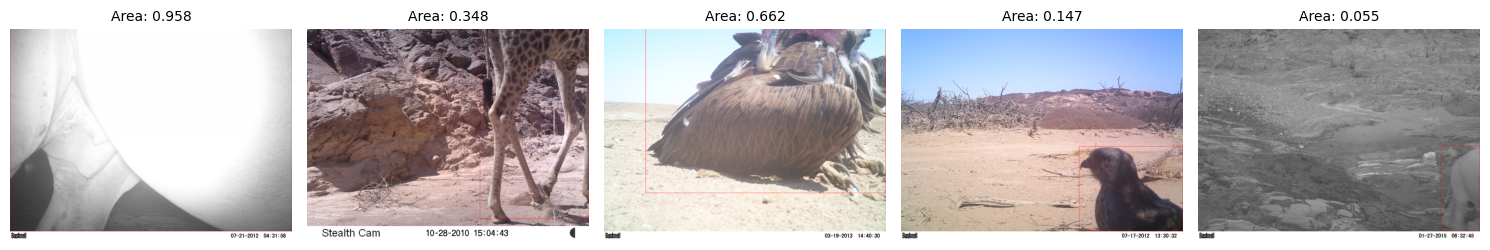

In [ ]:
# 5 zufällige Beispielbilder visualisieren
plt.figure(figsize=(15, 4))
samples = df_test_single_edge.sample(n=5, random_state=42)

for i, row in enumerate(samples.itertuples()):
    # Vollständiger Bildpfad (anpassen je nach Ordnerstruktur)
    img_path = os.path.join("balanced_dataset_split/balanced_dataset_split/test/", row.Path)
    print(f"Bild {i+1}: {img_path}")  

    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Bild nicht gefunden: {img_path}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Bounding Box zurück in Pixelkoordinaten
    h_img, w_img = img.shape[:2]
    x1 = int(row.x * w_img)
    y1 = int(row.y * h_img)
    x2 = int((row.x + row.w) * w_img)
    y2 = int((row.y + row.h) * h_img)
    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Area: {row.Area:.3f}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.savefig("images/test_edge_bboxes_examples.pdf", dpi=300)
plt.show()

In [63]:
# CBIR-Ergebnisse laden
df_cbir = pd.read_csv("CBIR/cbir_detailed_ViT_bs64+augm+iNat_cosine.csv")

# Paths in df_cbir auf gleichen Stil bringen
df_cbir["Path"] = df_cbir["Path"].str.replace(r"^.*?balanced_dataset_split/balanced_dataset_split/test/", "", regex=True)

# Mergen nach Path
df_merged = pd.merge(df_test_single_edge, df_cbir, on="Path", how="left")

# Übersicht
print(df_merged[["Path", "Precision@5", "Recall@5", "AP", "Top-1 Accuracy"]].head())

                                             Path  Precision@5  Recall@5   AP  \
0  acinonyx jubatus/acinonyx jubatus_PICT0051.JPG          1.0  0.057471  1.0   
1  acinonyx jubatus/acinonyx jubatus_PICT0026.JPG          1.0  0.057471  1.0   
2  acinonyx jubatus/acinonyx jubatus_PICT0031.JPG          1.0  0.057471  1.0   
3  acinonyx jubatus/acinonyx jubatus_PICT0163.JPG          1.0  0.057471  1.0   
4  acinonyx jubatus/acinonyx jubatus_PICT0154.JPG          1.0  0.057471  1.0   

   Top-1 Accuracy  
0               1  
1               1  
2               1  
3               1  
4               1  


In [ ]:
# Durchschnittswerte berechnen
summary = df_merged[["Precision@5",  "AP", "Top-1 Accuracy"]].mean()
print("Durchschnittswerte für randnahe Einzel-Tierbilder:")
print(summary.round(4))

# CBIR-Ergebnisse für das ganze Testset laden (z. B. ViT mit cosine)
df_all = pd.read_csv("CBIR/cbir_detailed_ViT_bs64+augm+iNat_cosine.csv")

# Durchschnittswerte des gesamten Testsets
general_means = df_all[["Precision@5", "AP", "Top-1 Accuracy"]].mean()

# Durchschnittswerte für randnahe Einzelobjektbilder
edge_means = df_merged[["Precision@5", "AP", "Top-1 Accuracy"]].mean()

# Kombinieren für den Plot
df_compare = pd.DataFrame({
    "Truncated Animal Images": edge_means,
    "All Test Images": general_means
}).T


📊 Durchschnittswerte für randnahe Einzel-Tierbilder:
Precision@5       0.8163
AP                0.8552
Top-1 Accuracy    0.8393
dtype: float64


/tmp/ipykernel_2897000/685156307.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap("Blues")


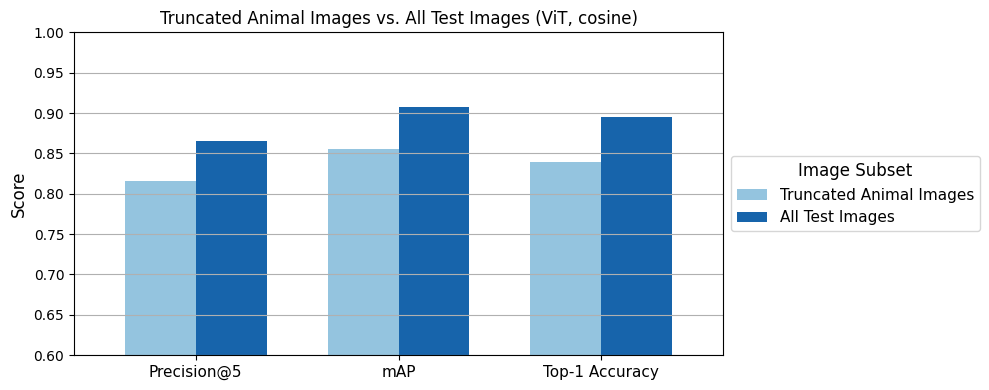

In [78]:
# Zwei Farben aus der "Blues" Colormap wählen
blues = cm.get_cmap("Blues")
colors = [blues(0.4), blues(0.8)]  # dunkleres und helleres Blau

# AP in mAP umbenennen
df_compare_renamed = df_compare.rename(columns={"AP": "mAP"})

# Plot erstellen
ax = df_compare_renamed.T.plot(
    kind="bar", figsize=(10, 4), width=0.7, color=colors
)

plt.title("Truncated Animal Images vs. All Test Images (ViT, cosine)")
plt.ylabel("Score", fontsize=12)
plt.ylim(0.6, 1.0)
plt.xticks(rotation=0,fontsize=11)
plt.grid(axis="y")

# Legende außerhalb platzieren
plt.legend(title="Image Subset", title_fontsize=12, loc="center left", bbox_to_anchor=(1.0, 0.5), fontsize=11)

plt.tight_layout()
plt.savefig("images/cbir_metrics_comparison_edge_vs_all.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Datei-Namen vereinheitlichen
df_test["rel_path"] = df_test["file_path"].str.replace(r"^.*?balanced_dataset_split/", "", regex=True)
df_edge_bboxes["rel_path"] = df_edge_bboxes["Path"].str.replace(r"^.*?balanced_dataset_split/", "", regex=True)

# Klasse zuordnen
df_edge_bboxes = df_edge_bboxes.merge(
    df_test[["rel_path", "label"]],
    on="rel_path",
    how="left"
)
